In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import re
import numpy as np
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup
import torch
import time
from tqdm.notebook import trange, tqdm

from transformers import (
    BertModel,
    BertConfig,
    BertTokenizer,
    BertForPreTraining
)

from pyknp import Juman

from gensim import models

In [3]:
import matplotlib.font_manager as fm
fonts = fm.findSystemFonts()

Matplotlib is building the font cache; this may take a moment.


In [4]:
print([[str(font), fm.FontProperties(fname=font).get_name()] for font in fonts[:10]])

[['/usr/share/texmf/fonts/opentype/public/lm/lmmonoproplt10-regular.otf', 'Latin Modern Mono Prop Light'], ['/usr/share/texmf/fonts/opentype/public/lm/lmmono9-regular.otf', 'Latin Modern Mono'], ['/usr/share/texmf/fonts/opentype/public/lm/lmsans9-regular.otf', 'Latin Modern Sans'], ['/usr/share/texmf/fonts/opentype/public/lm/lmromanunsl10-regular.otf', 'Latin Modern Roman Unslanted'], ['/usr/share/fonts/NotoSansCJKjp/NotoSansCJKjp-Medium.otf', 'Noto Sans CJK JP'], ['/usr/share/texmf/fonts/opentype/public/lm/lmroman6-regular.otf', 'Latin Modern Roman'], ['/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', 'Liberation Serif'], ['/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', 'Liberation Sans'], ['/usr/share/texmf/fonts/opentype/public/lm/lmroman10-italic.otf', 'Latin Modern Roman'], ['/usr/share/texmf/fonts/opentype/public/lm/lmromanslant12-regular.otf', 'Latin Modern Roman Slanted']]


In [5]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from  matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'

In [6]:
BERT_ROOT = "/home/jovyan/work/BERT/models/bert/Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers"

In [7]:
jm = Juman(timeout=15)

In [8]:
model = BertModel.from_pretrained(BERT_ROOT)
model.eval()

Some weights of the model checkpoint at /home/jovyan/work/BERT/models/bert/Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32006, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [9]:
vocab_file_path = os.path.join(BERT_ROOT, 'vocab.txt')
bert_tokenizer = BertTokenizer(vocab_file_path, do_lower_case=False, do_basic_tokenize=False)

# BeautifulSoup Scraping

In [15]:
url = [
    "https://dev.classmethod.jp/articles/pyknpjumann-tutorial/",
    "https://ux-jump.com/uxdesign-skill",
    "https://dev.classmethod.jp/articles/bert-text-embedding/",
    "https://news.yahoo.co.jp/articles/83124b73f1383bf32357b797ce730aa6515a53f2",
    "https://www.nikkansports.com/baseball/mlb/column/showtime/news/202112190000276.html",
    "https://blog.kikagaku.co.jp/nlp-service"
]

## Pattern1 : 冒頭 512文字での特徴抽出

 https://www.reddit.com/r/MLQuestions/comments/nb4zdg/using_bert_on_long_documents_510_words_for_text/  
 結構色々なところで，冒頭 (or 終端) 512単語を抽出すると良いというコメントを参考

In [24]:
def get_vector_top512(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    _text = soup.get_text()
    
    _lines = [line.strip() for line in _text.splitlines()]
    _texts_p = [ t.replace('\n', '') for t in _lines if re.match('\S', t) ]
    _texts_p = [ t.replace('\u3300', '') for t in _texts_p ]
    _texts_p = [ t.replace('\u3000', '') for t in _texts_p ]
    _texts_p = [ t.replace('\uf002', '') for t in _texts_p ]
    
    sentence_result = []
    for i in tqdm(_texts_p, desc='Juman mrph analysis'):
        try:
            result = jm.analysis(i)
        except:
            continue
        tokens = [mrph.midasi for mrph in result.mrph_list()]
        sentence_result.append(tokens)
        
    sentence = "[CLS] "
    for sent in sentence_result:
        _token = " ".join(sent + ["[SEP]"])
        sentence = sentence + _token
        
    bert_tokens = bert_tokenizer.tokenize(sentence)
    token_ids = bert_tokenizer.convert_tokens_to_ids(bert_tokens)
    
    tokens_tensor = torch.tensor(token_ids[0:512]).unsqueeze(0)
    with torch.no_grad():
        outputs = model(tokens_tensor)
    vector = outputs[0].max(0)[0].numpy()
    result = np.mean(vector, axis=0)
    
    return {
        "url": url,
        "title": soup.find('title').text,
        "vector": result
    }

In [23]:
vectors = []
for _url in url:
    _result = get_vector_top512(_url)
    vectors.append(_result)

Juman mrph analysis:   0%|          | 0/82 [00:00<?, ?it/s]

Juman mrph analysis:   0%|          | 0/120 [00:00<?, ?it/s]

Juman mrph analysis:   0%|          | 0/165 [00:00<?, ?it/s]

Juman mrph analysis:   0%|          | 0/15 [00:00<?, ?it/s]

Juman mrph analysis:   0%|          | 0/321 [00:00<?, ?it/s]

InvalidParameter: byte size of input string (4281) is greater than maximum allowed (4096)
backtrace:
    resetForInput at /jumanpp-2.0.0-rc2/src/core/analysis/analyzer_impl.cc:19
    analyze at /jumanpp-2.0.0-rc2/src/core/analysis/analyzer.cc:46
    analyzeWith at /jumanpp-2.0.0-rc2/src/core/input/stream_reader.h:38

Juman mrph analysis:   0%|          | 0/112 [00:00<?, ?it/s]

In [18]:
vector_list = [x['vector'] for x in vectors]
label_list = [x['title'] for x in vectors]
X_reduced = PCA(n_components=2, random_state=0).fit_transform(vector_list)

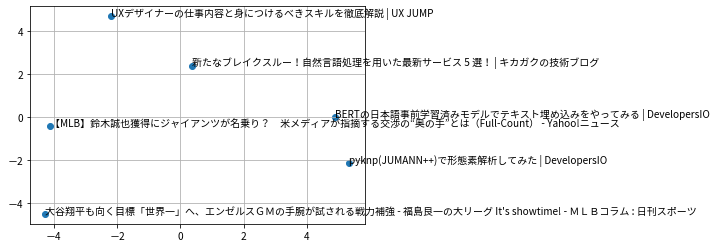

In [19]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.grid()
for label, x, y in zip(label_list, X_reduced[:, 0], X_reduced[:, 1]):
    plt.annotate(label, xy=(x, y))

In [17]:
sentence_result = []
for i in tqdm(_texts_p):
    try:
        result = jm.analysis(i)
    except:
        continue
    tokens = [mrph.midasi for mrph in result.mrph_list()]
    sentence_result.append(tokens)

  0%|          | 0/82 [00:00<?, ?it/s]

In [18]:
sentence = "[CLS] "
for sent in sentence_result:
    _token = " ".join(sent + ["[SEP]"])
    sentence = sentence + _token

In [26]:
bert_tokens = bert_tokenizer.tokenize(sentence)
token_ids = bert_tokenizer.convert_tokens_to_ids(bert_tokens)

In [46]:
tokens_tensor = torch.tensor(token_ids[0:512]).unsqueeze(0)
with torch.no_grad():
    outputs = model(tokens_tensor)
vector = outputs[0].max(0)[0].numpy()

## Pattern2 : 各文章ごとに特徴生成する

In [19]:
list_bert_tokens = []
for tokens in tqdm(sentence_result):
    bert_tokens = bert_tokenizer.tokenize(" ".join(["[CLS]"] + tokens + ["[SEP]"]))
    token_ids = bert_tokenizer.convert_tokens_to_ids(bert_tokens)
    list_bert_tokens.append(token_ids) 

  0%|          | 0/81 [00:00<?, ?it/s]

In [20]:
result = []
for tenso in tqdm(list_bert_tokens):
    tokens_tensor = torch.tensor(tenso).unsqueeze(0)
    with torch.no_grad():
        outputs = model(tokens_tensor)
    result.append(outputs)

  0%|          | 0/81 [00:00<?, ?it/s]

In [21]:
result[0]['last_hidden_state'].max(0)[0]

tensor([[ 0.3174, -0.5060, -0.8484,  ..., -0.3971,  0.4762, -0.6710],
        [-1.2558, -0.2342, -0.7860,  ..., -1.3362, -0.1698,  0.4197],
        [-1.0266, -0.0844, -0.4328,  ..., -1.4944, -0.0697,  0.6240],
        ...,
        [-1.5063, -0.0836, -0.6289,  ..., -1.5272, -0.4572,  0.8062],
        [-0.3357,  0.3042, -0.6383,  ..., -1.5855, -0.0196,  0.7578],
        [-0.2178,  0.0191, -0.2973,  ..., -0.2228,  0.0274,  0.0497]])